In [1]:
from __future__ import print_function
import torch
import numpy as np
import matplotlib.pyplot as plt


dtype = torch.float
device = torch.device("cpu")
# device = torch.device("cuda:0") # Uncomment this to run on GPU



In [3]:
#Create a randon tensor

#tensor size
#m,n,t= 110,6,120
#r=5
# create sparse tensor X with ones at idx 
#idx = torch.LongTensor([[0, 1, 1],
#                          [2, 0, 2],
 #                          [1,1,2]]) #idx for 
#value = torch.ones(3)
#X=torch.sparse.FloatTensor(idx, value, torch.Size([m,n,t])).to_dense()

In [11]:
#Generate a random tensor
m,n,t= 110,25,120
r=5
X= torch.rand(m,n,t)
X.shape

#make last row = 0 to mimic missing data 
X_missing = X.clone()
X_missing[-1:,:,:]=0 

In [12]:
#2 dimensional SVD 
def mat_svd(X,r):
    #Mode-1 folding
    X1= X.reshape(m,n*t)
    U,S,V= torch.svd(X1,some=True, compute_uv=True) 
    U1=U[:,:r]
    #Mode-2 folding
    X2= X.reshape(m*t,n) 
    U,S,V= torch.svd(X2,some=True, compute_uv=True) 
    V1=V[:,:r]
    return U1,V1

#calculate MAE:
def get_mae(tensor1,tensor2):
    error = (tensor1-tensor2).abs().sum().item()
    return error 


#Slice Iteration: for one iteration 
def slice_iteration(tensor,r):
    new_tensor = torch.empty((m,n,t)) 
    #get U,V
    U,V = mat_svd(tensor, r)
    
    #update tensor 
    UU = torch.mm(U,torch.t(U))
    VV = torch.mm(V,torch.t(V))
    for i in range(t):
        new_tensor[:,:,i] = torch.mm(torch.mm(UU, tensor[:,:,i]),VV) 
    return new_tensor 

Code stopped at iteration = 8, and mae difference = 0.6151261925697327


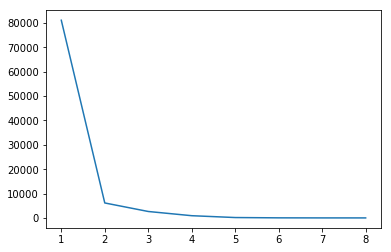

The MAE between X_imputed and X_original is 83086.5625


In [20]:
#Slice Learning 
def slice_learning(tensor_train,r,max_iteration=50,convergence=1):
    m,n,t= tensor_train.shape 
    new_tensor= torch.empty((m,n,t)) 
    old_tensor = tensor_train 
    mae_all=[]
    
    mae = 100 
    #Iterative slice learning 
    for i in range(max_iteration): 
        if mae > 1: 
            new_tensor = slice_iteration(old_tensor,r)
            mae= get_mae(new_tensor,old_tensor) 
            mae_all.append(mae)
            old_tensor = new_tensor 
    
    #plot MAE difference between iterations   
    max_i = len(mae_all)

    print('Code stopped at iteration = %s, and mae difference = %s'%(max_i,mae_all[-1]))
    plt.plot(np.linspace(1,max_i,max_i),mae_all)
    plt.show()
    return new_tensor 

X_imputed = slice_learning(X_missing,5)

#find the MAE difference between X_imputed and X_original
print('The MAE between X_imputed and X_original is %s' %(get_mae(X_imputed,X)))


# OLD CODE

In [ ]:
# -------------- OLD CODE --------------------------- 
#Update S based on U1, V1
def update_s(U, X, V, r ):
    new_s = torch.empty((r,r,t))
    for i in range(t): 
        m1 = torch.mm(torch.t(U),X[:,:,i]) #torch.t = transpose
        m2 = torch.mm(m1,V)
        new_s[:,:,i]=m2
    return new_s

S=update_s(U1,X,V1,r)
S.shape

In [16]:
#Compute Z:
def update_z(U,V,S):
    new_z = torch.empty((m,n,t))
    for i in range(t): 
        S_t=S[:,:,i]
        m1 = torch.mm(U,S_t)
        m2 = torch.mm(m1,torch.t(V))
        new_z[:,:,i]=m2
    return new_z
Z=update_z(U1,V1,S)
Z.shape


torch.Size([6, 8, 6])

code stopped at t=49 at error=36.49571990966797


tensor([[[0.7201, 0.5984, 0.3334, 0.4058, 0.7745, 0.7246],
         [0.3365, 0.5038, 0.7196, 0.2490, 0.5259, 0.6062],
         [0.5745, 0.3454, 0.5292, 0.3431, 0.6280, 0.2065],
         [0.2914, 0.4961, 0.7749, 0.8096, 0.6014, 0.4088],
         [0.1296, 0.6716, 0.5586, 0.8720, 0.5304, 0.8850],
         [0.4683, 0.5141, 0.9509, 0.5084, 0.5966, 0.5021],
         [0.5702, 0.4816, 0.4932, 0.5030, 0.6627, 0.4745],
         [0.4946, 0.4086, 0.6385, 0.2987, 0.5679, 0.3797]],

        [[0.4001, 0.4960, 0.5261, 0.6821, 0.2922, 0.6455],
         [0.5114, 0.3261, 0.6590, 0.4451, 0.3297, 0.3082],
         [0.2923, 0.3635, 0.5312, 0.3355, 0.5925, 0.2037],
         [0.2609, 0.3352, 0.5319, 0.6949, 0.5019, 0.1892],
         [0.3022, 0.2974, 0.3956, 0.9719, 0.0465, 0.5117],
         [0.4090, 0.6108, 0.7789, 0.7017, 0.4466, 0.1541],
         [0.2970, 0.4567, 0.5146, 0.6162, 0.4007, 0.3750],
         [0.3722, 0.4233, 0.6094, 0.4297, 0.4484, 0.2216]],

        [[0.2426, 0.7154, 0.6921, 0.5383, 0.2818, 0.

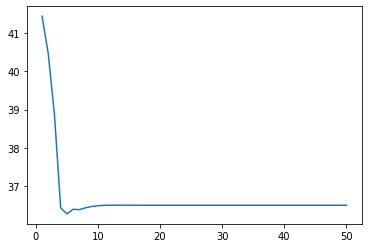

In [38]:
#wrap up everything 
def tensor_svd(Z0,r,T=50):
    #warm-start Z
    R=torch.rand(Z0.shape)
    error=100
    error_all=[]
    for t in range(T):
        if error > 1: 
            U1,V1= mat_svd(R,r)
            S=update_s(U1,R,V1,r)
            Z1=update_z(U1,V1,S)
            R=Z1
             
            #calculate and record error 
            error=(Z1-Z0).pow(2).sum().item()
            error_all.append(error)
    
    #plot error change
    L=len(error_all)
    plt.plot(np.linspace(1,L,L),error_all)
    
    print('code stopped at t=%s at error=%s'%(t,error))    
    return Z1    
            
tensor_svd(X,r)         

In [36]:
# useful website for operations: https://jhui.github.io/2018/02/09/PyTorch-Basic-operations/
X_5= torch.cat((X,X,X), dim=2) # Concatenate X's in the 0 dimension

X.shape, X_5.shape

(torch.Size([6, 6, 6]), torch.Size([6, 6, 18]))

In [39]:
from processing_csv import *

ModuleNotFoundError: No module named 'processing_csv'